# Capstone Project - The Battle of Neighborhoods

## Introduction

Clearly define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to solve or execute. Remember that data science problems always target an audience and are meant to help a group of stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about your problem.

#### "Opening a new Restaurant Recommendation?"  
A friend of mine want to open a restaurant in New York and he asked to provide him with a shortlist of the top 5 locations.

He told me that this was his dream and he wanted my help to decide how and where he should start.

A restaurant should be unique in the area and shouldn't have alot of competitor near it in order to be able to excel at the begining. he also thinks that transportation is a very important factor along with surrounding shops & venues.


## Data

#### 1. Describe the data that you will be using to solve the problem or execute your idea. Remember that you will need to use the Foursquare location data to solve the problem or execute your idea. You can absolutely use other datasets in combination with the Foursquare location data. So make sure that you provide adequate explanation and discussion, with examples, of the data that you will be using, even if it is only Foursquare location data.

Data required is as per below:

New York's data: https://cocl.us/new_york_dataset


In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline




def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '' # your Foursquare ID
    CLIENT_SECRET = '' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df



def get_venue_details(venue_id):
        
    CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
    CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [2]:
new_york_data=get_new_york_data()


In [3]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
# Find Restaurants

In [15]:
#prepare neighborhood list that contains any resturant
column_names=['Borough', 'Neighborhood', 'ID','Name']
resto_list=pd.DataFrame(columns=column_names)
count=1
column_names=['Borough', 'Neighborhood', 'Category','Name','Latitude', 'Longitude']
venues_pd=pd.DataFrame(columns=column_names)
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude) 
    resturants=venues[venues['Category']=='Restaurant']  
    venues_pd=venues_pd.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'Category': venues['Category'],
                                                'Name' : name,'Latitude':Latitude, 'Longitude':Longitude
                                               }, ignore_index=True)
    print('(',count,'/',len(new_york_data),')','Resturants in '+Neighborhood+', '+Borough+':'+str(len(resturants)))
    for resturant_detail in resturants.values.tolist():
        id, name , category=resturant_detail
        resto_list = resto_list.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1
    

( 1 / 306 ) Resturants in Wakefield, Bronx:1
( 2 / 306 ) Resturants in Co-op City, Bronx:1
( 3 / 306 ) Resturants in Eastchester, Bronx:0
( 4 / 306 ) Resturants in Fieldston, Bronx:1
( 5 / 306 ) Resturants in Riverdale, Bronx:1
( 6 / 306 ) Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Resturants in Norwood, Bronx:1
( 10 / 306 ) Resturants in Williamsbridge, Bronx:2
( 11 / 306 ) Resturants in Baychester, Bronx:0
( 12 / 306 ) Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Resturants in City Island, Bronx:0
( 14 / 306 ) Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Resturants in University Heights, Bronx:1
( 16 / 306 ) Resturants in Morris Heights, Bronx:1
( 17 / 306 ) Resturants in Fordham, Bronx:0
( 18 / 306 ) Resturants in East Tremont, Bronx:1
( 19 / 306 ) Resturants in West Farms, Bronx:0
( 20 / 306 ) Resturants in High  Bridge, Bronx:0
( 21 / 306 ) Resturants in Melrose, Bronx:0
( 

( 163 / 306 ) Resturants in Queens Village, Queens:0
( 164 / 306 ) Resturants in Hollis, Queens:1
( 165 / 306 ) Resturants in South Jamaica, Queens:1
( 166 / 306 ) Resturants in St. Albans, Queens:0
( 167 / 306 ) Resturants in Rochdale, Queens:0
( 168 / 306 ) Resturants in Springfield Gardens, Queens:0
( 169 / 306 ) Resturants in Cambria Heights, Queens:1
( 170 / 306 ) Resturants in Rosedale, Queens:0
( 171 / 306 ) Resturants in Far Rockaway, Queens:0
( 172 / 306 ) Resturants in Broad Channel, Queens:0
( 173 / 306 ) Resturants in Breezy Point, Queens:0
( 174 / 306 ) Resturants in Steinway, Queens:1
( 175 / 306 ) Resturants in Beechhurst, Queens:1
( 176 / 306 ) Resturants in Bay Terrace, Queens:0
( 177 / 306 ) Resturants in Edgemere, Queens:0
( 178 / 306 ) Resturants in Arverne, Queens:0
( 179 / 306 ) Resturants in Rockaway Beach, Queens:2
( 180 / 306 ) Resturants in Neponsit, Queens:0
( 181 / 306 ) Resturants in Murray Hill, Queens:1
( 182 / 306 ) Resturants in Floral Park, Queens:0
( 

In [10]:
resto_list.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4d8d1bd4d265236a66daea16,Lovette's
1,Bronx,Co-op City,4be2b79d660ec9284d04ca3b,Townhouse Restaurant
2,Bronx,Fieldston,5a5117dafebf316fdc2115da,Blue Charcoal Grill
3,Bronx,Riverdale,59dbf19108f521354f91e748,The Hill Bistro
4,Bronx,Kingsbridge,59dbf19108f521354f91e748,The Hill Bistro


In [16]:
resto_list.shape

(166, 4)

In [29]:
venues_pd[venues_pd['Neighborhood']=="Bay Terrace"].head(5)

,Borough,Neighborhood,Category,Name,Latitude,Longitude
175,Queens,Bay Terrace,0 Bakery...,Erin's Isle,40.782843,-73.776802
235,Staten Island,Bay Terrace,0 Donut Shop 1 Italian R...,Ariana's Catering Hall,40.553988,-74.139166


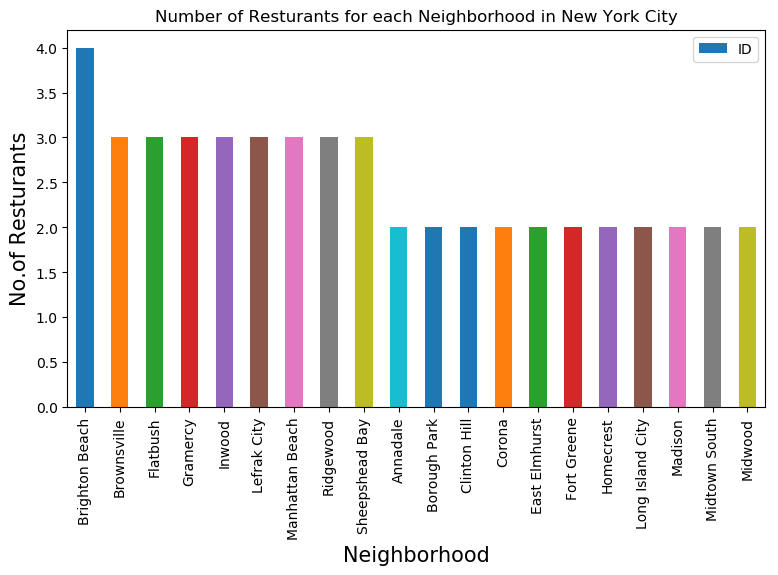

In [18]:
#PLOT RESTO FIGURE ASCENDING ORDER
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Resturants', fontsize=15)
#giving a bar plot
resto_list.groupby('Neighborhood')['ID'].count().nlargest(20).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

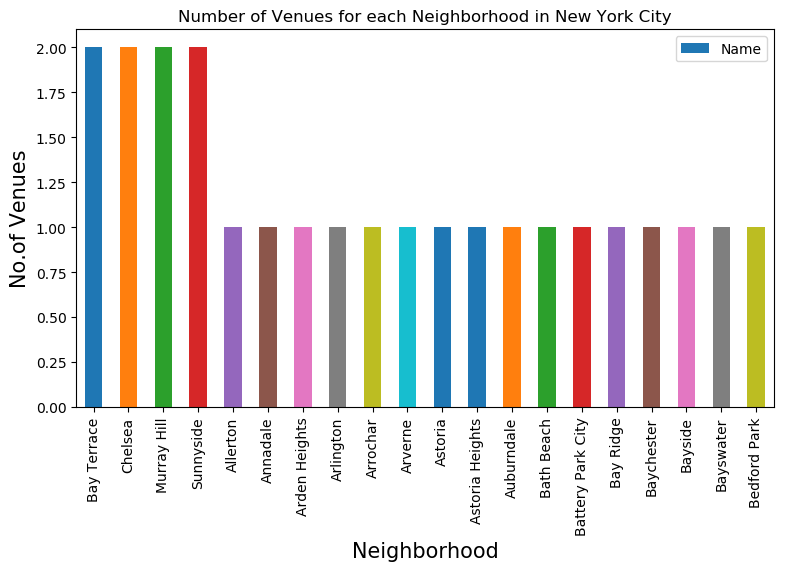

In [28]:
#find neighborhouds with best venues

#PLOT RESTO FIGURE ASCENDING ORDER
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Venues for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Venues', fontsize=15)
#giving a bar plot
venues_pd.groupby('Neighborhood')['Name'].count().nlargest(20).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

<p>
    <b>Discussion</b>

  We need to filter neighborhoods based on the related venues as Metro, Bus Stop, Shop & Service etc...
  Future Enhancement***
</p>


In [30]:
venues_pd[venues_pd['Neighborhood']=="Brighton Beach"].head(5)

,Borough,Neighborhood,Category,Name,Latitude,Longitude
51,Brooklyn,Brighton Beach,0 Gourmet Shop...,Archestratus Books & Foods,40.576825,-73.965094


In [31]:
venues_pd[venues_pd['Neighborhood']=="Brownsville"].head(5)

,Borough,Neighborhood,Category,Name,Latitude,Longitude
60,Brooklyn,Brownsville,0 Performing Arts Venue 1 ...,Maison Yaki,40.66395,-73.910235


In [42]:
resto_list[resto_list['Neighborhood']=="Bay Terrace"].head(5)

,Borough,Neighborhood,ID,Name


In [43]:
resto_list[resto_list['Neighborhood']=="Chelsea"].head(5)

,Borough,Neighborhood,ID,Name


In [44]:
resto_list[resto_list['Neighborhood']=="Murray Hill"].head(5)

,Borough,Neighborhood,ID,Name
73,Manhattan,Murray Hill,56c72cbccd1086304ddcfbdb,Bedford & Co.
108,Queens,Murray Hill,56bfecffcd10eae1fc27fb20,Joah 좋아


In [45]:
resto_list[resto_list['Neighborhood']=="Sunnyside"].head(5)

,Borough,Neighborhood,ID,Name
86,Queens,Sunnyside,4ca8fed6a6e08cfa1d029594,Tropical Restaurant


<p>
    <b>Conclusion</b>

 Brighton Beach and Brownsville are between the highest neighborhoud who have restaurants, though they have below 2 venues***<br/>
 Bay Terrace, Chelsea have the highest venues but no restaurants exists there.
 
 As a conclusion its a great opportunity to open a restaurnt in these areas with high venues and no competition whatsoever!
    </p>
